# t-SNE Exploration

In [340]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

df = pd.read_csv('../data/processed/NY_SLI_ATTOM_NEW.csv')
df_numeric_data = df.drop(columns=[
    'Lead Gooseneck, Pigtail or Connector Currently Present',
    'Current Public Side SL Material',
    'Was Public SL Material Ever Previously Lead',
    'Public SL Material Verification Method',
    'Customer SL Material',
    'Lead Solder Present',
    'Customer SL Size',
    'SL Category', 
    'Note', 
    'Current SL Material Category', 'Lead Connector Present Category',
    'Current Public Side SL Material Category',
    'Was Public SL Material Ever Previously Lead Category',
    'Public SL Size Numeric', 
    'attomID',
    'Service Line Locality',
    'Street Address',
    'State',
    'Public SL Size',
    'Customer SL Material Verification Method',
    'POU or POE Treatment Present',
    'Building Type',
    'prop_class',
    'size_ind',
    'Public SL Installation Year',
    'Public SL Material Verification Method Category',
    'Public SL Size Category',
    'Zip Code',
    'Customer SL Material Category',
])
print(df_numeric_data.columns)
def safe_float(x):
    try:
        return float(x)
    except (ValueError, TypeError):
        return False
def safe_install_year(x) -> bool:
    return safe_float(x) > 1500 and safe_float(x) < 2025

def condition_numeric(x):
    if x == 'NaN' or type(x) == float: # only if nan
        return 0
    if x == 'FAIR':
        return 1
    if x == 'AVERAGE':
        return 2
    if x == 'GOOD':
        return 3
    if x == 'EXCELLENT':
        return 4
df_numeric_data[['Longitude', 'Latitude']] = (
    df_numeric_data['Location']
    .str.extract(r'POINT\s*\(\s*([-.\d]+)\s+([-.\d]+)\s*\)')
    .astype(float)
)
df_numeric_data = df_numeric_data.drop(columns='Location')
df_numeric_data = df_numeric_data[df_numeric_data['living_size'] < 10_000]
df_numeric_data['construction_condition'] = df_numeric_data['construction_condition'].apply(condition_numeric)
df_numeric_data['Public SL Installation or Replacement Date'] = df_numeric_data.apply(lambda row: row['year_built'] if not safe_install_year(row['Public SL Installation or Replacement Date']) else float(row['Public SL Installation or Replacement Date']), axis=1 )
for col in df_numeric_data:
    if col != 'SL Category Cleaned':
        df_numeric_data[col] = df_numeric_data[col].apply(float)

len(df_numeric_data[df_numeric_data['SL Category Cleaned'] != 'Lead'])

Index(['Public SL Installation or Replacement Date',
       'Customer SL Installation or Replacement Date', 'Location',
       'SL Category Cleaned', 'lot_size2', 'year_built', 'living_size', 'beds',
       'baths_total', 'levels', 'market_total_value',
       'construction_condition'],
      dtype='object')


318

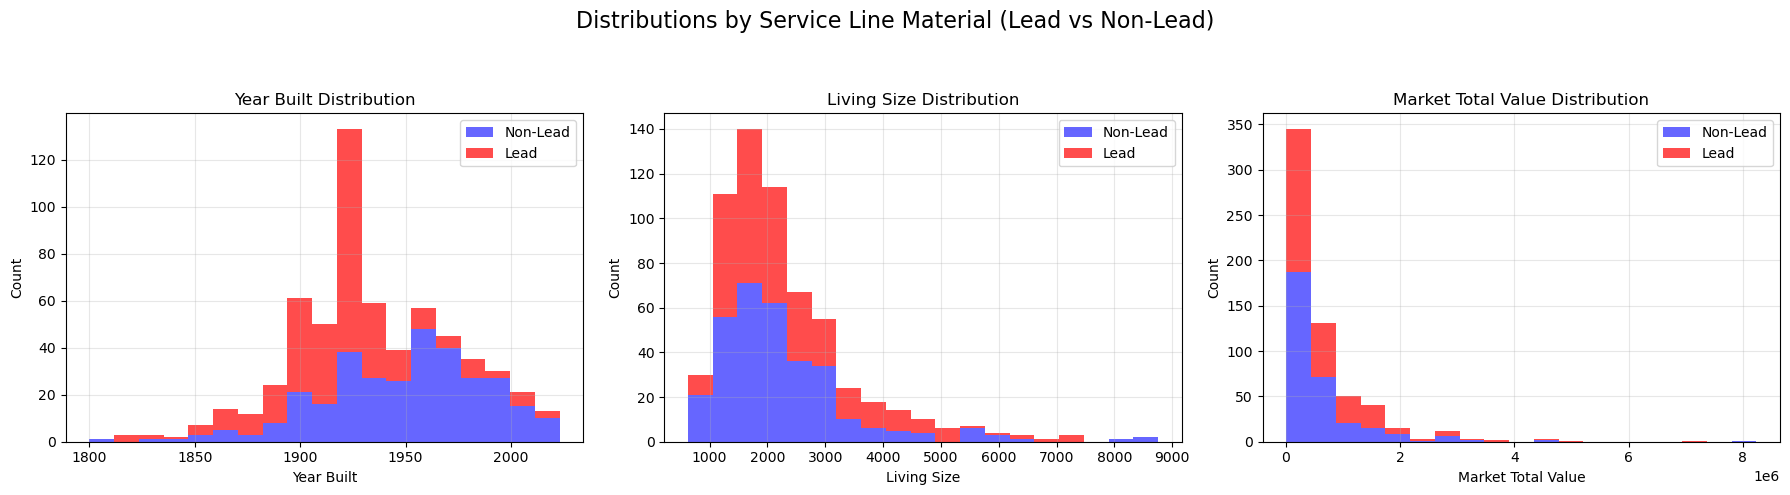

In [341]:


# Define which columns to plot
cols = ['year_built', 'living_size', 'market_total_value']

# Create subplots (1 row, 3 columns)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle("Distributions by Service Line Material (Lead vs Non-Lead)", fontsize=16)

for ax, col in zip(axes, cols):
    # Drop NaN
    lead = df_numeric_data[df_numeric_data['SL Category Cleaned'] == 'Lead'][col].dropna()
    nonlead = df_numeric_data[df_numeric_data['SL Category Cleaned'] != 'Lead'][col].dropna()
    
    # Define common bins
    bins = np.linspace(df_numeric_data[col].min(), df_numeric_data[col].max(), 20)
    
    # Compute histograms
    lead_counts, _ = np.histogram(lead, bins=bins)
    nonlead_counts, _ = np.histogram(nonlead, bins=bins)
    
    # Compute bin centers
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    
    # Plot stacked bars
    ax.bar(bin_centers, nonlead_counts, width=np.diff(bins), color='blue', alpha=0.6, label='Non-Lead')
    ax.bar(bin_centers, lead_counts, width=np.diff(bins), bottom=nonlead_counts, color='red', alpha=0.7, label='Lead')
    
    ax.set_title(col.replace('_', ' ').title() + ' Distribution', fontsize=12)
    ax.set_xlabel(col.replace('_', ' ').title())
    ax.set_ylabel('Count')
    ax.grid(alpha=0.3)
    ax.legend()

plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()

In [342]:
y = df_numeric_data['SL Category Cleaned']
print(len(df_numeric_data.columns))
df_numeric_data = df_numeric_data.drop(columns='SL Category Cleaned')
X = df_numeric_data.to_numpy()
print(len(X[0]))
# X = np.hstack([X[:, 0:2], X[:, 3:]])
print(len(X[0]))

y = y[~np.isnan(X).any(axis=1)]
X = X[~np.isnan(X).any(axis=1)]
X

13
12
12


array([[ 1.976000e+03,  1.976000e+03,  7.020000e+03, ...,  2.000000e+00,
        -7.681887e+01,  4.209131e+01],
       [ 1.958000e+03,  1.958000e+03,  6.250000e+03, ...,  2.000000e+00,
        -7.679192e+01,  4.208219e+01],
       [ 1.965000e+03,  1.965000e+03,  2.368000e+04, ...,  0.000000e+00,
        -7.679436e+01,  4.209401e+01],
       ...,
       [ 1.957000e+03,  1.970000e+03,  1.611700e+04, ...,  2.000000e+00,
        -7.393029e+01,  4.103141e+01],
       [ 1.930000e+03,  1.930000e+03,  5.625000e+03, ...,  2.000000e+00,
        -7.624717e+01,  4.304666e+01],
       [ 1.928000e+03,  1.928000e+03,  6.250000e+03, ...,  3.000000e+00,
        -7.624677e+01,  4.304577e+01]])

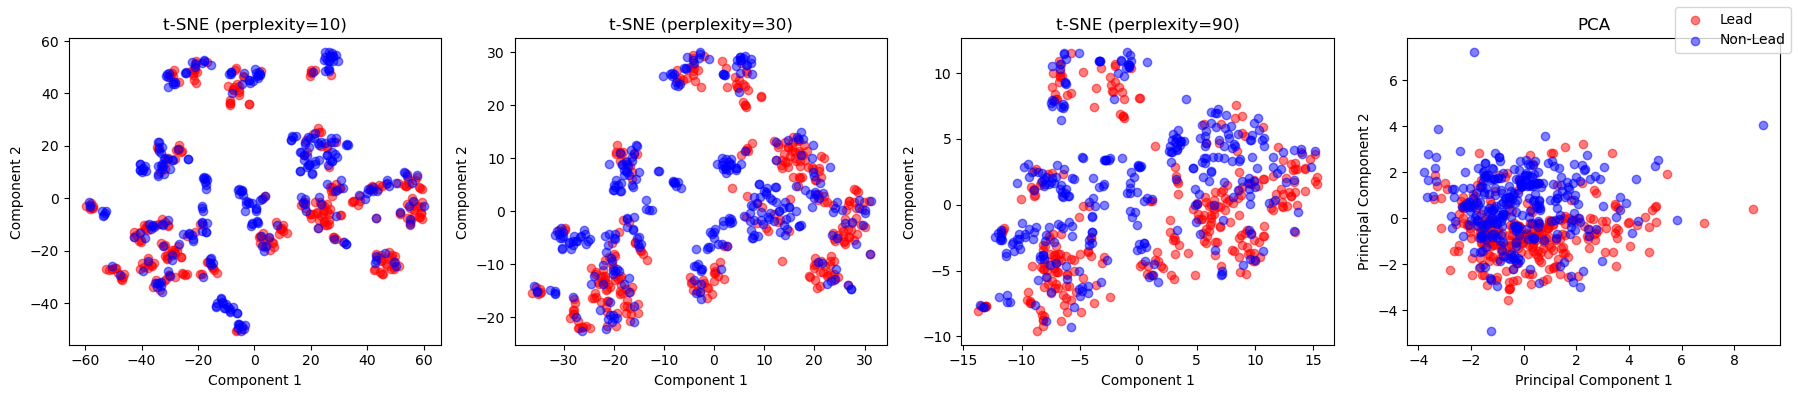

In [350]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

perplexities = [10, 30, 90]
colors = {'Lead': 'red', 'Non-Lead': 'blue'}

fig, axes = plt.subplots(1, 4, figsize=(18, 4))

for ax, perp in zip(axes[:-1], perplexities):
    tsne = TSNE(n_components=2, perplexity=perp, random_state=42)
    X_reduced = tsne.fit_transform(X_scaled)
    
    for material, color in colors.items():
        idx = y == material
        ax.scatter(X_reduced[idx, 0], X_reduced[idx, 1], c=color, alpha=0.5, label=material)
    
    ax.set_title(f"t-SNE (perplexity={perp})")
    ax.set_xlabel("Component 1")
    ax.set_ylabel("Component 2")

# PCA
scaler = StandardScaler()
pca = PCA(n_components=2)

X_scaled = scaler.fit_transform(X)
X_reduced = pca.fit_transform(X_scaled)

colors = {'Lead': 'red', 'Non-Lead': 'blue'}
for material, color in colors.items():
    idx = y == material
    axes[-1].scatter(X_reduced[idx, 0], X_reduced[idx, 1], c=color, alpha=0.5, label=material)
    axes[-1].set_xlabel("Principal Component 1")
    axes[-1].set_ylabel("Principal Component 2")

axes[-1].set_title('PCA')
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc="upper right")
plt.tight_layout()
plt.show()

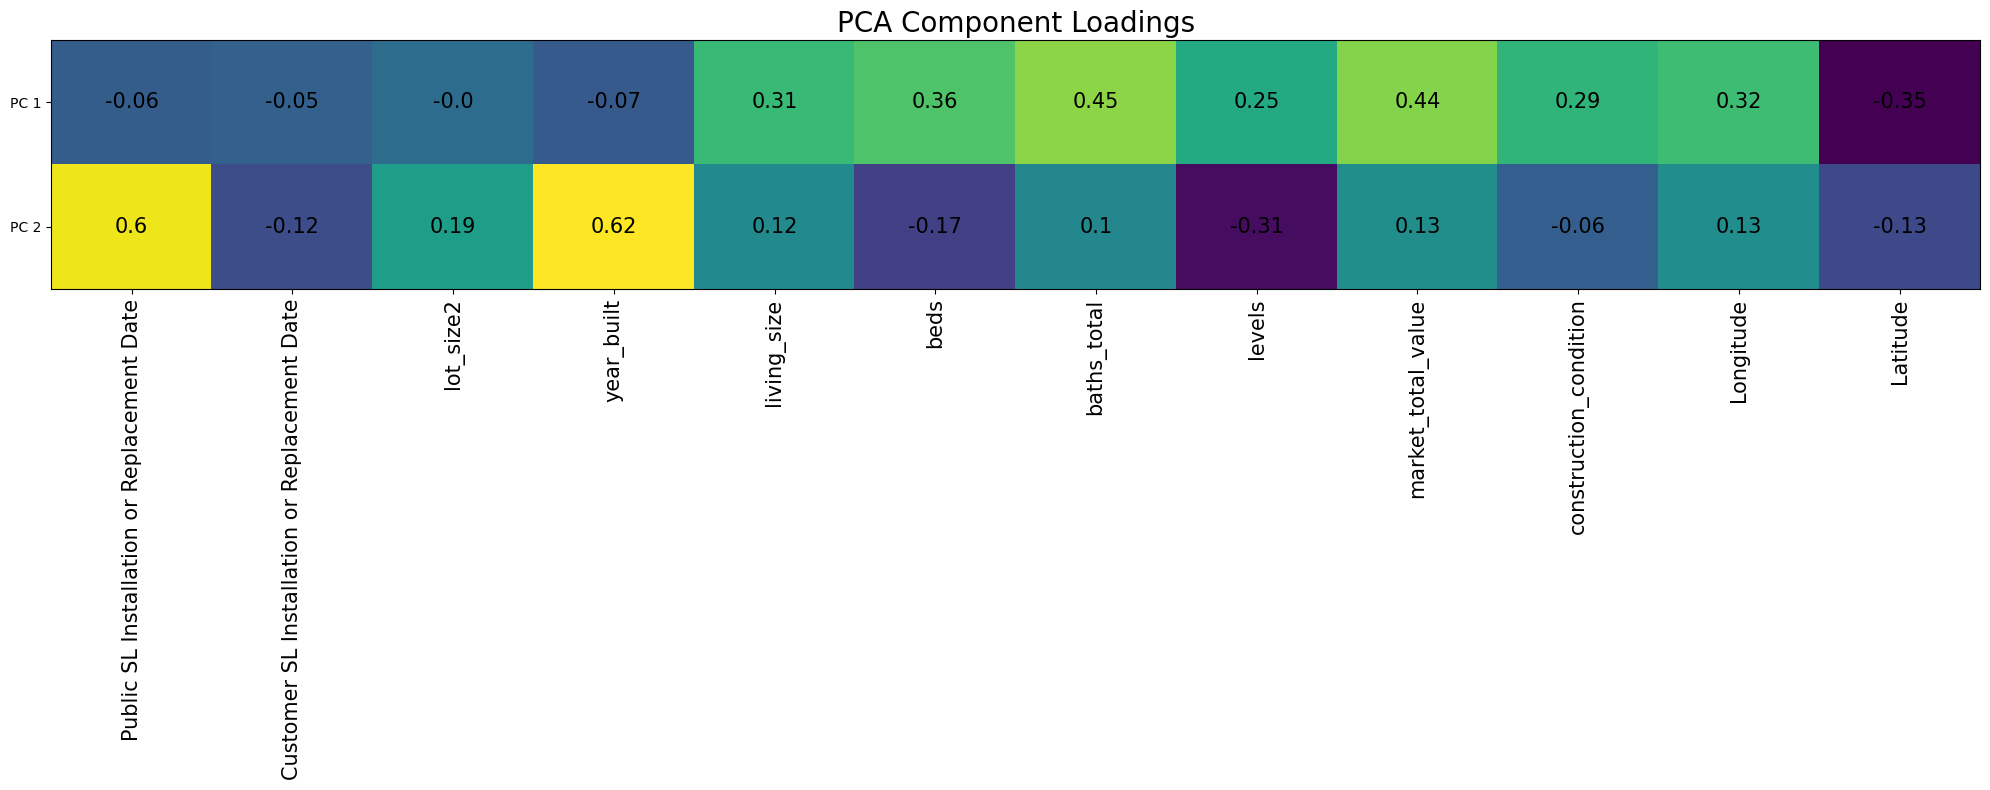

In [363]:
pc_labels = ['PC 1', 'PC 2']

fig, ax = plt.subplots(figsize=(20, 8))  # flipped dimensions
im = ax.imshow(pca.components_, aspect='auto')  # transposed here

ax.set_yticks(range(len(pc_labels)))
ax.set_yticklabels(pc_labels)

numeric_labels = df_numeric_data.columns


ax.set_xticks(range(len(numeric_labels)))
ax.set_xticklabels(numeric_labels, rotation=90, fontsize=15)

# Annotate values
components_rounded = np.round(pca.components_, 2)
for i in range(len(pc_labels)):
    for j in range(len(numeric_labels)):
        text = ax.text(j, i, components_rounded[i, j],
                       ha="center", va="center", color="black", fontsize=15)

plt.title("PCA Component Loadings", fontsize=20)
plt.tight_layout()
plt.show()


Text(0.5, 1.0, 'PCA')

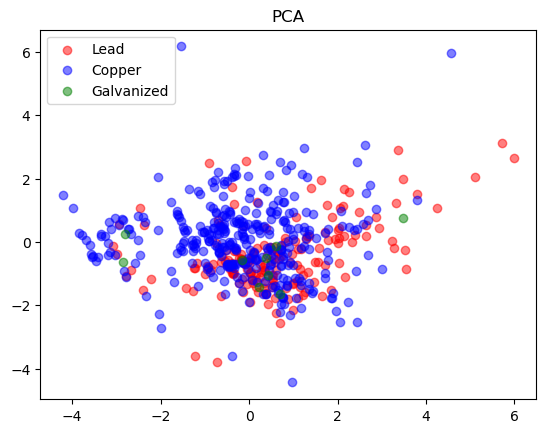

In [249]:
scaler = StandardScaler()
pca = PCA(n_components=2)

X_scaled = scaler.fit_transform(X)
X_reduced = pca.fit_transform(X_scaled)

colors = {'Lead': 'red', 'Copper': 'blue', 'Galvanized': 'green'}
for material, color in colors.items():
    idx = y == material
    plt.scatter(X_reduced[idx, 0], X_reduced[idx, 1], c=color, alpha=0.5, label=material)

y.value_counts()
plt.legend()
plt.title('PCA')